In [1]:
%matplotlib inline
import quantstats as qs
from pathlib import Path
import pandas as pd
import vectorbt as vbt
import pandas_ta as ta
import asyncio
import itertools
from datetime import datetime
from IPython import display
import numpy as np

import plotly.graph_objects as go

print("Package Versions:")
print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"vectorbt >= v0.18.1")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")



days_per_year = 365
output = Path("/output")
qs.extend_pandas()
# btc = qs.utils.download_returns("BTC-USD")

Package Versions:
Numpy v1.20.0
Pandas v1.2.5
vectorbt >= v0.18.1

Pandas TA v0.3.14b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



# vectorbt Theme and Settings

In [2]:

cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
# vbt.settings.portfolio["init_cash"] = 100
vbt.settings.portfolio["fees"] = 0.0025 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0025 # 0.25%
# vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,100.0
size,inf
size_type,amount
fees,0.0025
fixed_fees,0.0
slippage,0.0025
reject_prob,0.0
min_size,0.0


In [3]:
rtree_holdings = pd.read_csv("RWM WisdomTree Crypto Index.csv")
rtree_holdings

,Ticker,Weight,Description
0,AAVE,3.0,Decentralized Liquidity Provider
1,BTC,37.7,Layer-1 Payment System
2,CRV,2.5,Decentralized Finance Lending Protocol
3,ENJ,2.4,Non-Fungible Token Platform
4,ETH,17.8,Layer-1 Smart Contract Platform
5,FTM,2.5,Layer-1 Smart Contract Platform
6,GRT,2.6,Indexing Services
7,LINK,3.4,Decentralized Oracle Network
8,LUNA,7.6,Layer-1 Protocol for Stablecoins
9,MANA,3.1,Decentralized Virtual Reality


In [4]:
yfinance_base = "-USD"
binance_base = "USDT"
yfinance_tickers = rtree_holdings["Ticker"]+yfinance_base
binance_tickers = rtree_holdings["Ticker"]+binance_base

In [5]:
rtree_holdings["Ticker"]

0      AAVE
1       BTC
2       CRV
3       ENJ
4       ETH
5       FTM
6       GRT
7      LINK
8      LUNA
9      MANA
10    MATIC
11      SOL
12    SUSHI
13      UNI
14      YFI
Name: Ticker, dtype: object

# Create some helper functions

In [29]:
def combine_stats(pf: vbt.portfolio.base.Portfolio, ticker: str, strategy: str, mode: int = 0):
    header = pd.Series({
        "Run Time": ta.get_time(full=False, to_string=True),
        "Mode": "LIVE" if mode else "TEST",
        "Strategy": strategy,
        "Direction": vbt.settings.portfolio["signal_direction"],
        "Symbol": ticker.upper(),
        "Fees [%]": 100 * vbt.settings.portfolio["fees"],
        "Slippage [%]": 100 * vbt.settings.portfolio["slippage"],
        "Accumulate": vbt.settings.portfolio["accumulate"],
    })
    rstats = pf.returns_stats().dropna(axis=0).T
    stats = pf.stats().dropna(axis=0).T
    joint = pd.concat([header, stats, rstats])
    return joint[~joint.index.duplicated(keep="first")]

def earliest_common_index(d: dict):
    """Returns index of the earliest common index of all DataFrames in the dict"""
    min_date = None
    for df in d.values():
        new_df = df.copy()
        new_df.dropna(axis=0, how="all", inplace=True)
        if min_date is None:
            min_date = new_df.index[0]
        elif min_date < new_df.index[0]:
            min_date = new_df.index[0]
    return min_date

def earliest_date(d: dict):
    """Returns index of the earliest index of all DataFrames in the dict"""
    min_date = None
    for df in d.values():
        new_df = df.copy()
        new_df.dropna(axis=0, how="all", inplace=True)
        if min_date is None:
            min_date = new_df.index[0]
        elif min_date > new_df.index[0]:
            min_date = new_df.index[0]
    return min_date

def dl(tickers: list, same_start: bool = False, **kwargs):
    if isinstance(tickers, str):
        tickers = [tickers]
    
    if not isinstance(tickers, list) or len(tickers) == 0:
        print("Must be a non-empty list of tickers or symbols")
        return

    if "limit" in kwargs and kwargs["limit"] and len(tickers) > kwargs["limit"]:
        from itertools import islice            
        tickers = list(islice(tickers, kwargs["limit"]))
        print(f"[!] Too many assets to compare. Using the first {kwargs['limit']}: {', '.join(tickers)}")

    print(f"[i] Downloading: {', '.join(tickers)}")

    received = {}
    if len(tickers):
        _df = pd.DataFrame()
        for ticker in tickers:
            received[ticker] = _df.ta.ticker(ticker, **kwargs)
            print(f"[+] {ticker}{received[ticker].shape} {ta.get_time(full=False, to_string=True)}")
    
    if same_start and len(tickers) > 1:
        earliestci = earliest_common_index(received)
        print(f"[i] Earliest Common Date: {earliestci}")
        result = {ticker:df[df.index > earliestci].copy() for ticker,df in received.items()}
    else:
        result = received
    print(f"[*] Download Complete\n")
    return result

def dtmask(df: pd.DataFrame, start: datetime, end: datetime):
    return df.loc[(df.index >= start) & (df.index <= end), :].copy()

def show_data(d: dict):
    [print(f"{t}[{df.index[0]} - {df.index[-1]}]: {df.shape} {df.ta.time_range:.2f} years") for t,df in d.items()]
    
def trade_table(pf: vbt.portfolio.base.Portfolio, k: int = 1, total_fees: bool = False):
    if not isinstance(pf, vbt.portfolio.base.Portfolio): return
    k = int(k) if isinstance(k, int) and k > 0 else 1

    df = pf.trades.records[["status", "direction", "size", "entry_price", "exit_price", "return", "pnl", "entry_fees", "exit_fees"]]
    if total_fees:
        df["total_fees"] = df["entry_fees"] + df["exit_fees"]

    print(f"\nLast {k} of {df.shape[0]} Trades\n{df.tail(k)}\n")
    
def convert_index_to_naive_timezone(df: pd.DataFrame):
    """Converts the index of a DataFrame to the naive timezone. Helpful for quantstats which doesn't use timezone aware indexes"""
    return df.tz_localize(None)

# Data Acquisition
Import the holdings from the rtree holdings csv file

In [7]:
# prices = dl(yfinance_tickers.to_list())

In [8]:
# prices

In [9]:
# prices["BTC-USD"]["Close"].plot_drawdown()

In [10]:
# for ticker in prices.keys():
#     print(f'{ticker} | Drawdown Plot')
#     prices[ticker]["Close"].plot_drawdown()

In [11]:
# Get data from binance
binance_prices = vbt.BinanceData.download(
    binance_tickers,
    interval='1d',
)

2020-10-15 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 2it [00:01,  1.31it/s]
2017-08-17 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 4it [00:03,  1.30it/s]
2020-08-15 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 2it [00:01,  1.41it/s]
2019-04-18 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 3it [00:02,  1.32it/s]
2017-08-17 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 4it [00:02,  1.36it/s]
2019-06-11 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 3it [00:02,  1.46it/s]
2020-12-17 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 1it [00:00,  1.27it/s]
2019-01-16 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 3it [00:02,  1.45it/s]
2020-08-21 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 2it [00:01,  1.27it/s]
2020-08-06 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 2it [00:02,  1.05s/it]
2019-04-26 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 3it [00:02,  1.01it/s]
2020-08-11 00:00:00+00:00 - 2022-04-26 00:00:00+00:00: : 2it [00:01,  1.37it/s]
2020-09-01 00:00:00+00:00 - 2022-04-26 0

In [ ]:
for ticker in binance_prices.data.keys():
    print(f'{ticker} | Drawdown Plot')
    binance_prices.data[ticker]["Close"].plot_drawdown()

In [ ]:
qs.reports.basic(convert_index_to_naive_timezone(binance_prices.data["AAVEUSDT"]["Close"]), periods_per_year=365)

In [15]:
qs.reports.metrics(convert_index_to_naive_timezone(binance_prices.data["AAVEUSDT"]["Close"]), mode="basic", title="AAVEUSDT", display=False, periods_per_year=365)

,AAVEUSDT
Start Period,2017-08-17
End Period,2022-04-26
Risk-Free Rate,0.0
Time in Market,0.33
Cumulative Return,3.02
CAGR﹪,0.34
Sharpe,0.76
Sortino,1.22
Sortino/√2,0.86
Omega,1.21


In [13]:
stats = pd.DataFrame()
for ticker in binance_tickers:
    report = qs.reports.metrics(convert_index_to_naive_timezone(binance_prices.data[ticker]["Close"]), mode="basic", title=ticker, display=True, periods_per_year=365)
    stats[ticker] = report[ticker]
stats

                    AAVEUSDT
------------------  ----------
Start Period        2017-08-17
End Period          2022-04-26
Risk-Free Rate      0.0%
Time in Market      33.0%

Cumulative Return   301.87%
CAGR﹪              34.5%

Sharpe              0.76
Sortino             1.22
Sortino/√2          0.86
Omega               1.21

Max Drawdown        -81.6%
Longest DD Days     342

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.72

Payoff Ratio        1.14
Profit Factor       1.21
Common Sense Ratio  1.37
CPC Index           0.71
Tail Ratio          1.14
Outlier Win Ratio   13.82
Outlier Loss Ratio  2.24

MTD                 -16.56%
3M                  9.09%
6M                  -43.86%
YTD                 -31.94%
1Y                  -50.42%
3Y (ann.)           58.99%
5Y (ann.)           34.5%
10Y (ann.)          34.5%
All-time (ann.)     34.5%

Avg. Drawdown       -19.39%
Avg. Drawdown Days  33
Recovery Factor     3.7
Ulcer Index         0.28
Serenity Index      0.86
                    BT

,AAVEUSDT,BTCUSDT,CRVUSDT,ENJUSDT,ETHUSDT,FTMUSDT,GRTUSDT,LINKUSDT,LUNAUSDT,MANAUSDT,MATICUSDT,SOLUSDT,SUSHIUSDT,UNIUSDT,YFIUSDT
Start Period,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17,2017-08-17
End Period,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26
Risk-Free Rate,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Time in Market,33.0%,100.0%,36.0%,65.0%,100.0%,62.0%,29.0%,70.0%,36.0%,37.0%,64.0%,37.0%,36.0%,35.0%,37.0%
,,,,,,,,,,,,,,,
Cumulative Return,301.87%,832.92%,-61.68%,662.09%,880.61%,"3,061.11%",225.46%,"2,576.20%","22,127.63%","3,166.06%","23,808.26%","2,896.82%",-63.91%,146.7%,199.48%
CAGR﹪,34.5%,60.94%,-18.48%,54.15%,62.65%,108.73%,28.59%,101.45%,216.28%,110.19%,221.23%,106.37%,-19.52%,21.22%,26.33%
,,,,,,,,,,,,,,,
Sharpe,0.76,1.0,0.38,0.94,1.0,1.2,0.69,1.18,1.56,1.09,1.49,1.22,0.35,0.62,0.7
Sortino,1.22,1.47,0.58,1.53,1.45,2.07,1.4,1.89,3.03,2.44,2.73,2.08,0.54,1.15,1.2


In [30]:
earliest_common_index(binance_prices.data)

Timestamp('2020-12-17 00:00:00+0000', tz='UTC', freq='D')

In [33]:

first_date          = earliest_date(binance_prices.data).strftime("%Y-%m-%d")
common_start        = earliest_common_index(binance_prices.data).strftime('%Y-%m-%d')
end                 = binance_prices.data["BTCUSDT"].index[-1].strftime('%Y-%m-%d')
title               = f"Common Timeframe ({common_start}) - ({end})"
full_range_title    = f"Full Range       ({first_date}) - ({end})"

print(title)
print(full_range_title)

Common Timeframe (2020-12-17)   -     (2022-04-26)
Full Range       (2017-08-17)     -     (2022-04-26)


In [34]:

common_start_stats = pd.DataFrame()
for ticker in binance_tickers:
    report = qs.reports.metrics(convert_index_to_naive_timezone(binance_prices.data[ticker]["Close"][common_start:end]), mode="basic", title=ticker, display=True, periods_per_year=365)
    common_start_stats[ticker] = report[ticker]
common_start_stats

                    AAVEUSDT
------------------  ----------
Start Period        2020-12-17
End Period          2022-04-26
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   103.21%
CAGR﹪              68.68%

Sharpe              1.06
Sortino             1.65
Sortino/√2          1.17
Omega               1.16

Max Drawdown        -81.6%
Longest DD Days     342

Gain/Pain Ratio     0.16
Gain/Pain (1M)      1.44

Payoff Ratio        1.1
Profit Factor       1.16
Common Sense Ratio  1.41
CPC Index           0.66
Tail Ratio          1.21
Outlier Win Ratio   3.85
Outlier Loss Ratio  2.78

MTD                 -16.56%
3M                  9.09%
6M                  -43.86%
YTD                 -31.94%
1Y                  -50.42%
3Y (ann.)           68.68%
5Y (ann.)           68.68%
10Y (ann.)          68.68%
All-time (ann.)     68.68%

Avg. Drawdown       -16.9%
Avg. Drawdown Days  36
Recovery Factor     1.26
Ulcer Index         0.51
Serenity Index      0.17
                   

,AAVEUSDT,BTCUSDT,CRVUSDT,ENJUSDT,ETHUSDT,FTMUSDT,GRTUSDT,LINKUSDT,LUNAUSDT,MANAUSDT,MATICUSDT,SOLUSDT,SUSHIUSDT,UNIUSDT,YFIUSDT
Start Period,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17,2020-12-17
End Period,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26,2022-04-26
Risk-Free Rate,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Time in Market,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%
,,,,,,,,,,,,,,,
Cumulative Return,103.21%,75.36%,304.27%,781.7%,360.78%,"5,133.52%",225.46%,-2.56%,"19,711.98%","2,086.64%","6,772.36%","5,783.93%",18.41%,131.35%,-29.87%
CAGR﹪,68.68%,51.31%,180.12%,397.8%,208.49%,1750.95%,138.73%,-1.89%,4839.63%,872.56%,2162.74%,1917.93%,13.27%,85.61%,-23.02%
,,,,,,,,,,,,,,,
Sharpe,1.06,0.92,1.44,1.74,1.62,2.39,1.29,0.64,2.91,1.89,2.53,2.72,0.85,1.11,0.46
Sortino,1.65,1.39,2.33,3.07,2.46,4.44,2.61,0.93,5.73,4.34,5.17,4.7,1.34,1.83,0.71


In [35]:
# Drop it in a CSV
common_start_stats.to_csv("rtree_holdings_stats.csv")

                           Strategy
-------------------------  ----------
Start Period               2017-08-17
End Period                 2022-04-26
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          832.92%
CAGR﹪                     60.94%

Sharpe                     1.0
Smart Sharpe               0.95
Sortino                    1.47
Smart Sortino              1.39
Sortino/√2                 1.04
Smart Sortino/√2           0.98
Omega                      1.17

Max Drawdown               -83.19%
Longest DD Days            1073
Volatility (ann.)          79.71%
Calmar                     0.73
Skew                       -0.29
Kurtosis                   7.31

Expected Daily %           0.13%
Expected Monthly %         4.0%
Expected Yearly %          45.09%
Kelly Criterion            7.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -6.64%
Expected Shortfall (cVaR)  -6.64%

Gain/Pain Ratio            0.17
Gain/Pain (1M)            

,Strategy
Start Period,2017-08-17
End Period,2022-04-26
Risk-Free Rate,0.0%
Time in Market,100.0%
,
...,...
Avg. Down Month,-13.1%
Win Days %,52.66%
Win Month %,50.88%
Win Quarter %,55.0%


,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-12-17,2018-12-15,2020-11-24,1073,-83.187054,-82.022922
2,2021-04-14,2021-07-20,2021-10-19,188,-53.141408,-50.634888
3,2021-11-09,2022-01-22,2022-04-26,168,-48.062216,-46.027602
4,2017-09-02,2017-09-14,2017-10-12,40,-34.041792,-25.626951
5,2021-01-09,2021-01-27,2021-02-08,30,-25.174846,-23.982272


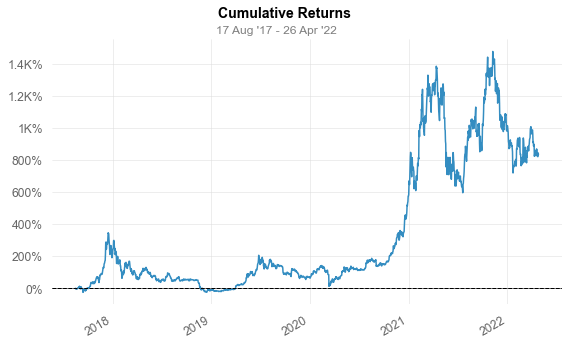

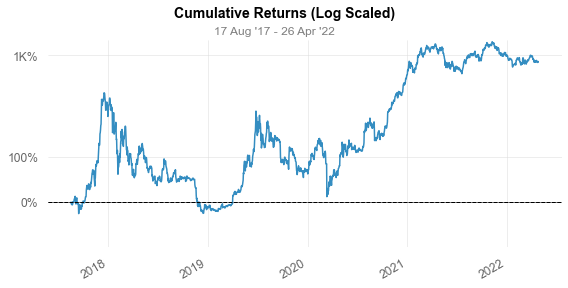

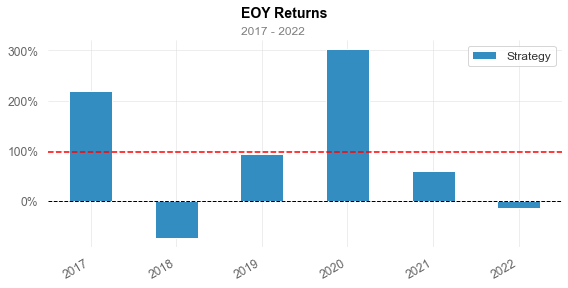

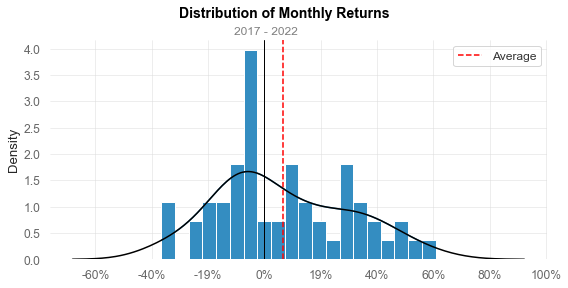

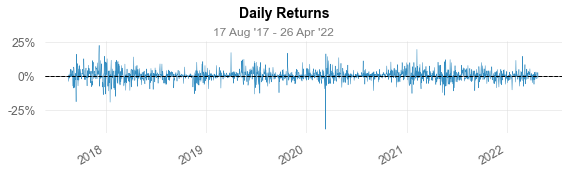

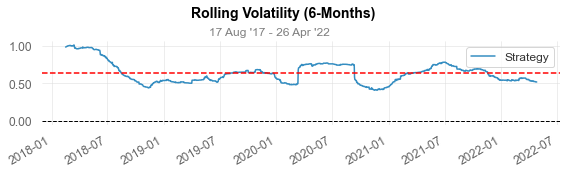

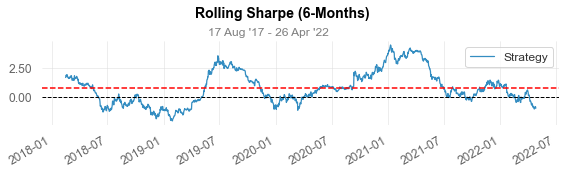

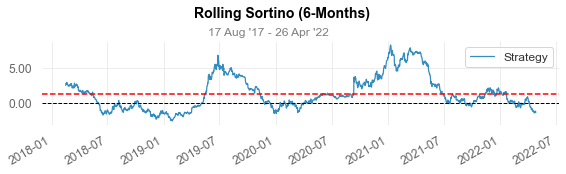

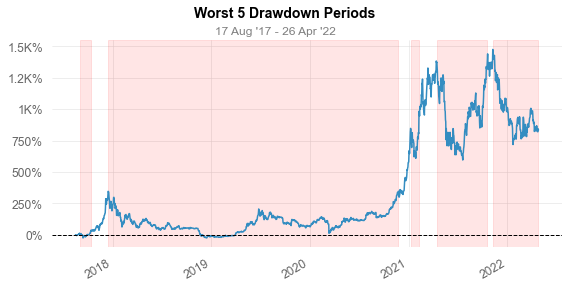

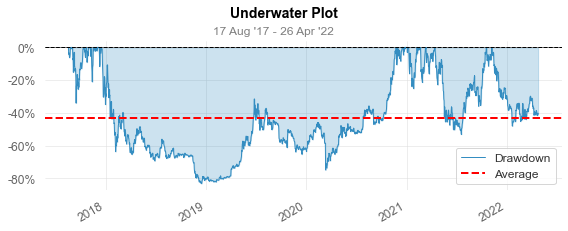

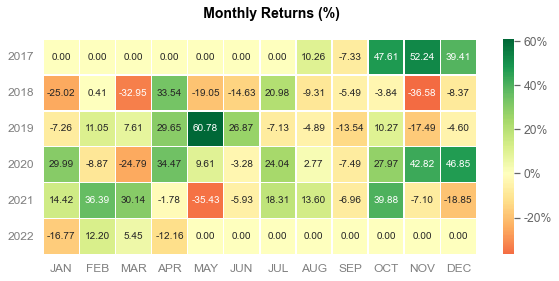

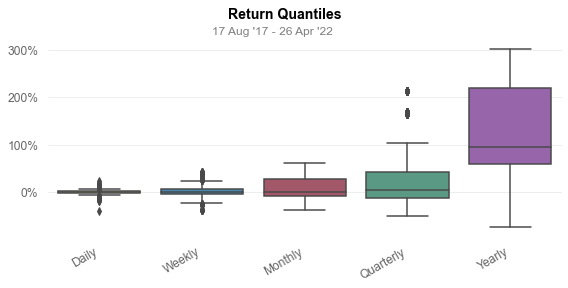

In [36]:
ticker = "BTCUSDT"
download_filename = f"{ticker}_tearsheet {common_start}--{end}.html"
full_range_filename = f"{ticker}_tearsheet {first_date}--{end}.html"
btc = convert_index_to_naive_timezone(binance_prices.data[ticker]["Close"][common_start:end])
btc_fullrange = convert_index_to_naive_timezone(binance_prices.data[ticker]["Close"])
# qs.reports.html(btc, title=title, download_filename=download_filename, periods_per_year=days_per_year)
qs.reports.full(btc_fullrange, periods_per_year=days_per_year)



In [40]:
dd = qs.stats.to_drawdown_series(btc_fullrange)
dd_info = qs.stats.drawdown_details(dd).sort_values(
    by='max drawdown', ascending=True)[:50]

In [41]:
dd_info.to_csv("btc-drawdowns.csv")

In [42]:
dd_info

,start,valley,end,days,max drawdown,99% max drawdown
13,2017-12-17,2018-12-15,2020-11-24,1073,-83.187054,-82.022922
28,2021-04-14,2021-07-20,2021-10-19,188,-53.141408,-50.634888
30,2021-11-09,2022-01-22,2022-04-26,168,-48.062216,-46.027602
4,2017-09-02,2017-09-14,2017-10-12,40,-34.041792,-25.626951
19,2021-01-09,2021-01-27,2021-02-08,30,-25.174846,-23.982272
25,2021-02-22,2021-02-28,2021-03-11,17,-21.378184,-19.687200
8,2017-11-05,2017-11-12,2017-11-16,11,-21.014559,-15.115215
27,2021-03-14,2021-03-25,2021-04-13,30,-16.170731,-14.520304
12,2017-12-08,2017-12-09,2017-12-15,7,-11.705103,-10.235677
29,2021-10-21,2021-10-27,2021-11-08,18,-11.496679,-8.594665


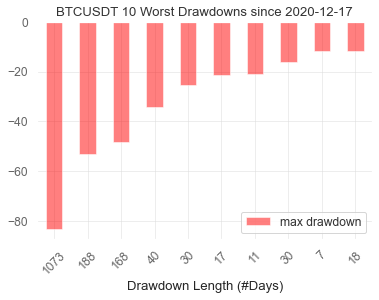

In [51]:
dd_info[:10].plot.bar(x="days", xlabel = "Drawdown Length (#Days)", y="max drawdown", rot = 45, color="red", alpha=.5, title=f"{ticker} 10 Worst Drawdowns since {common_start}")